# 1 Exploring the Data

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
print (digits.keys())
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


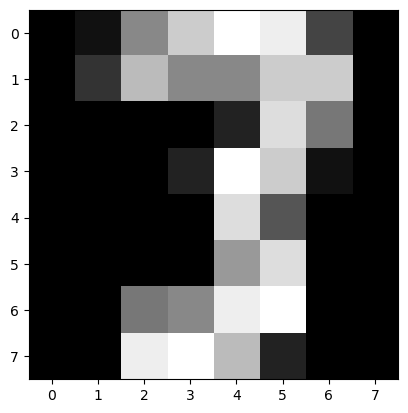

In [4]:
import numpy as np
import matplotlib . pyplot as plt
is_3 = target == 3
img = data[is_3][2].reshape(8, 8) # Reshape the data to 8x8 image
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest") # also try interpolation="bicubic"
plt.show()

In [109]:
from sklearn import model_selection

# Filter dataset to only include digits 3 and 9
is_3_or_9 = np.logical_or(target == 3, target == 9)
data_3_or_9 = data[is_3_or_9]
target_3_or_9 = target[is_3_or_9]

X_all = data_3_or_9
y_all = target_3_or_9
X_train , X_test , y_train , y_test =\
model_selection.train_test_split (X_all, y_all,
test_size = 0.4, random_state = 0)

# 2 Handcrafted Classifier

In [110]:
# Calculate mean images for digits 3 and 9
mean_3 = np.mean(data_3_or_9[target_3_or_9 == 3], axis=0)
mean_9 = np.mean(data_3_or_9[target_3_or_9 == 9], axis=0)

# Calculate pixel differences between mean images
pixel_diffs = np.abs(mean_3 - mean_9)

# Sort pixel differences in descending order and get indices of top k pixels
k = 5
top_k_indices = np.argsort(pixel_diffs)[::-1][:k]

# Print indices and corresponding differences for top k pixels
for i, idx in enumerate(top_k_indices):
    print(f"Pixel {i+1}: Index {idx}, Difference {pixel_diffs[idx]}")

Pixel 1: Index 26, Difference 8.957650273224044
Pixel 2: Index 18, Difference 8.795081967213115
Pixel 3: Index 29, Difference 8.454553734061932
Pixel 4: Index 36, Difference 6.954735883424408
Pixel 5: Index 21, Difference 4.788706739526411


In [111]:
def features2d(X):
    # Define indices of two pixels that seem to distinguish between 3's and 9's
    pixel1_idx = 26
    pixel2_idx = 18
    
    # Extract pixel values for the two chosen pixels
    pixel1 = X[:, pixel1_idx]
    pixel2 = X[:, pixel2_idx]
    
    # Construct 2-dimensional feature space using a linear combination of the two pixels
    features = np.stack([pixel1, pixel2], axis=1)
    
    return features

In [8]:
print(features2d(X_train))

[[11. 16.]
 [16. 10.]
 [ 4. 10.]
 ...
 [ 1.  7.]
 [ 3.  2.]
 [11. 11.]]


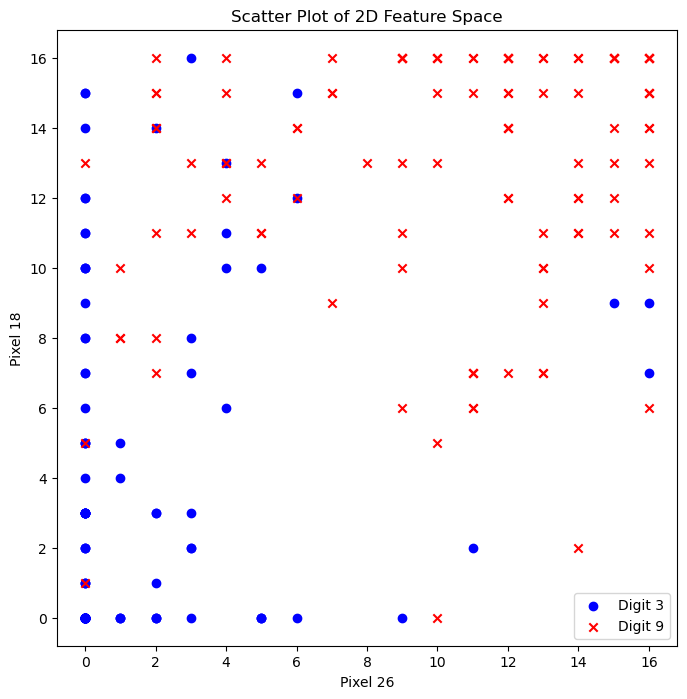

In [112]:
# Extract 2D features from training set
X_train_2d = features2d(X_train)

# Create scatter plot of 2D feature space
plt.figure(figsize=(8, 8))
plt.scatter(X_train_2d[y_train == 3, 0], X_train_2d[y_train == 3, 1], c='b', marker='o', label='Digit 3')
plt.scatter(X_train_2d[y_train == 9, 0], X_train_2d[y_train == 9, 1], c='r', marker='x', label='Digit 9')
plt.title('Scatter Plot of 2D Feature Space')
plt.xlabel('Pixel 26')
plt.ylabel('Pixel 18')
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import accuracy_score

def nearest_mean(training_features, training_labels, test_features):
    mean_3 = np.mean(training_features[training_labels == -1], axis=0)
    mean_9 = np.mean(training_features[training_labels == 1], axis=0)

    def dist(x, y):
        return np.sum((x - y) ** 2)

    predicted_labels = []
    for i in range(len(test_features)):
        dist_3 = dist(test_features[i], mean_3)
        dist_9 = dist(test_features[i], mean_9)
        if dist_3 < dist_9:
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)

    return np.array(predicted_labels)


y_train_new = np.where(y_train == 3, -1, 1) # Convert 3's to -1's and 9's to 1's
y_test_new = np.where(y_test == 3, -1, 1) # Convert 3's to -1's and 9's to 1's

# Compute training error
train_preds = nearest_mean(X_train_2d, y_train_new, X_train_2d)
train_acc = accuracy_score(y_train_new, train_preds)

# Compute test error
X_test_2d = features2d(X_test)
test_preds = nearest_mean(X_train_2d, y_train_new, X_test_2d)
test_acc = accuracy_score(y_test_new, test_preds)

print('Training error:', 1 - train_acc)
print('Test error:', 1 - test_acc)

Training error: 0.11059907834101379
Test error: 0.0821917808219178


In [114]:
# Create a grid of points to represent the feature space
x_min, x_max = np.min(X_train[:, 0]), np.max(X_train[:, 0])
y_min, y_max = np.min(X_train[:, 1]), np.max(X_train[:, 1])
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Compute the predicted labels for each point in the grid
nearest_mean_preds = nearest_mean(X_train, y_train, grid_points)
lin_preds = linear_classifier(X_train, y_train, grid_points)

# Reshape the predictions into an image
nearest_mean_img = nearest_mean_preds.reshape(xx.shape)
lin_img = lin_preds.reshape(xx.shape)

# Plot the decision regions
plt.figure(figsize=(12, 8))
plt.imshow(nearest_mean_img, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.4)
plt.imshow(lin_img, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.4)

# Plot the class means and test data
plt.scatter(X_test[y_test==-1, 0], X_test[y_test==-1, 1], c='blue', marker='o', label='Digit 3 (test data)')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='red', marker='s', label='Digit 9 (test data)')
plt.scatter(X_train[y_train==-1, 0], X_train[y_train==-1, 1], c='blue', marker='o', s=200, label='Digit 3 (training data)')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='s', s=200, label='Digit 9 (training data)')

# Plot the decision boundaries
plot_boundary(X_train, y_train, nearest_mean, label='Nearest Mean')
plot_boundary(X_train, y_train, linear_classifier, label='Linear Classifier')

plt.title('Decision Regions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.show()


c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


ValueError: operands could not be broadcast together with shapes (2,) (64,) 

In [22]:
def plot_boundary(X, y, clf, label=None):
    x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
    y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    preds = clf(X, y, grid_points)
    img = preds.reshape(xx.shape)
    plt.contour(xx, yy, img, levels=[0], colors='k', linestyles='--', label=label)


# 3 LDA

### 3.1 Implement LDA training

In [115]:
def fit_lda(training_features, training_labels):
    unique_labels = np.unique(training_labels)
    num_classes = len(unique_labels)
    num_features = training_features.shape[1]
    
    mu = np.zeros((num_classes, num_features))
    covmat = np.zeros((num_features, num_features))
    p = np.zeros(num_classes)
    
    for i, label in enumerate(unique_labels):
        # get all instances with the current label
        label_indices = np.where(training_labels == label)[0]
        num_instances = len(label_indices)
        p[i] = num_instances / len(training_labels)
        
        # compute class mean
        mu[i] = np.mean(training_features[label_indices], axis=0)
        
        # compute class covariance matrix
        covmat += np.cov(training_features[label_indices].T) * (num_instances - 1)
        
    # divide by the total number of instances to get the covariance matrix
    covmat /= len(training_labels)
    
    return mu, covmat, p

In [116]:
y_train_new = np.where(y_train == 3, -1, 1) # Convert 3's to -1's and 9's to 1's
y_test_new = np.where(y_test == 3, -1, 1) # Convert 3's to -1's and 9's to 1's

# Apply fit function to feature data from task 2
mu_2d, covmat_2d, p_2d = fit_lda(X_train_2d, y_train_new)
print(mu_2d)
print(covmat_2d)
print(p_2d)

[[ 1.45045045  3.5045045 ]
 [ 9.99056604 12.38679245]]
[[16.25100481  3.42470768]
 [ 3.42470768 17.84741593]]
[0.51152074 0.48847926]


In [117]:
# Apply fit function to full vector of 64 pixels
mu_full, covmat_full, p_full = fit_lda(X_train, y_train_new)
print(mu_full.shape)
print(covmat_full.shape)
print(p_full)

(2, 64)
(64, 64)
[0.51152074 0.48847926]


In [101]:
# filter out pixels that have a variance smaller than 0.001
variances = np.var(X_train, axis=0)
mask = variances >= 0.001
X_train_masked = X_train[:, mask]
X_test_masked = X_test[:,mask]

# Apply fit function to filterted vector
mu_masked, covmat_masked, p_masked = fit_lda(X_train_masked, y_train)

### 3.2 Implement LDA prediction

In [119]:
import numpy as np

def predict_lda(mu, covmat, p, test_features):

    covmat_inv = np.linalg.inv(covmat)
    beta = beta = np.dot(covmat_inv,(mu[1] - mu[0]).T)
    b = -0.5 * np.dot((mu[1] + mu[0]),beta) + np.log(p[0] / p[1])
    
    # calculate the discriminant function for each test instance
    discriminant = np.dot(test_features, beta) + b
    
    # assign the predicted label based on the maximum discriminant value
    predicted_labels = np.sign(discriminant)
    
    return predicted_labels

In [120]:
# call predict_lda() on the training and test data to obtain the predicted labels
train_predicted_labels = predict_lda(mu_masked, covmat_masked, p_masked, X_train_masked)
test_predicted_labels = predict_lda(mu_masked, covmat_masked, p_masked, X_test_masked)

# calculate the training and test error rates
train_error_rate = np.mean(train_predicted_labels != y_train_new)
test_error_rate = np.mean(test_predicted_labels != y_test_new)

print("Training error rate:", train_error_rate)
print("Test error rate:", test_error_rate)

Training error rate: 0.004608294930875576
Test error rate: 0.0136986301369863


### 3.3 Visualization

In [121]:
X_train_2d.shape

(217, 2)

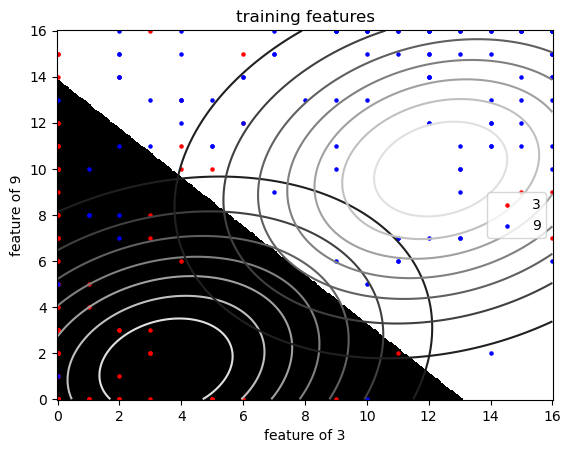

[13.53271285 20.56570789]
[[-0.78325883 -0.62169574]
 [ 0.62169574 -0.78325883]]


In [123]:
#with the feature function from 1.2
training_labels = y_train_new
mu, covmat, p = fit_lda(X_train_2d, training_labels)

predicted_train_labels = predict_lda(mu, covmat, p, X_train_2d)
predicted_test_labels = predict_lda(mu, covmat, p, X_train_2d)

beta = np.dot(np.linalg.inv(covmat), (mu[1] - mu[0]).T) 
b = -0.5 * (mu[1] + mu[0]).dot(beta) + np.log(p[0] / p[1])

training_features = np.array(X_train_2d)
x = np.linspace(min(training_features[:,0]), max(training_features[:,0]), 400)
y = np.linspace(min(training_features[:,1]), max(training_features[:,1]), 400)

def contour(x, y, mu):
    return 1 / np.sqrt(2*np.pi*np.linalg.det(covmat)) * np.exp(-0.5 * (np.array([x - mu[0], y - mu[1]]).dot(np.linalg.inv(covmat)).dot(np.array([x - mu[0], y - mu[1]]))))

z_contour_3 = np.array([np.zeros(len(x)) for i in range(len(y))])
z_contour_9 = np.array([np.zeros(len(x)) for i in range(len(y))])

for i in range(len(x)):
    for j in range(len(y)):
        z_contour_3[i][j] = contour(x[i], y[j], mu[0])
        z_contour_9[i][j] = contour(x[i], y[j], mu[1])

plt.contour(x, y, z_contour_3)
plt.contour(x, y, z_contour_9)

x, y = np.meshgrid(x, y)
z = np.sign(x * beta[0] + y * beta[1] + b)
plt.pcolormesh(x, y, z)
plt.scatter(training_features[y_train == 3, 0], training_features[y_train == 3, 1], color = "red", label = "3", s = 5)
plt.scatter(training_features[y_train == 9, 0], training_features[y_train == 9, 1], color = "blue", label = "9", s = 5)
plt.title("training features")
plt.xlabel("feature of 3")
plt.ylabel("feature of 9")
plt.legend()
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(covmat)
print(eigenvalues)
print(eigenvectors)

In [ ]:
#with all pixels except dead pixels as features

mu, covmat, p = fit_lda(X_train_masked, training_labels)
test_predicted_labels = predict_lda(mu, covmat, p, X_test_masked)
train_predicted_labels = predict_lda(mu, covmat, p, X_train_masked)

# calculate the training and test error rates
train_error_rate = np.mean(train_predicted_labels != y_train_new)
test_error_rate = np.mean(test_predicted_labels != y_test_new)

print("Training error rate:", train_error_rate)
print("Test error rate:", test_error_rate)

### 3.4 Quantitative performance evaluation

# 4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fit_svm(training_features, training_labels, lam=1.0, lr=0.1, max_iter=1000, plot=True):
    # Initialize parameters
    np.random.seed(0)
    beta = np.random.normal(size=training_features.shape[1])
    b = 0.0

    # Define helper functions
    def hinge_loss(x, y, beta, b):
        return np.maximum(1 - y * (np.dot(x, beta) + b), 0)
    
    def loss(beta, b, training_features, training_labels, lam):
        return 0.5 * np.dot(beta, beta) + lam * np.mean(hinge_loss(training_features, training_labels, beta, b))
    
    def grad_beta(beta, b, training_features, training_labels, lam):
        mask = hinge_loss(training_features, training_labels, beta, b) > 0
        return beta + lam * np.mean(-training_labels[:, np.newaxis] * training_features * mask[:, np.newaxis], axis=0)
    
    def grad_b(beta, b, training_features, training_labels, lam):
        mask = hinge_loss(training_features, training_labels, beta, b) > 0
        return lam * np.mean(-training_labels * mask)

    # Run gradient descent
    train_errors = []
    losses = []
    lr_schedule = [lr, lr/10] * (max_iter // 2)
    for t in range(max_iter):
        # Update learning rate
        lr_t = lr_schedule[t]

        # Compute gradients
        grad_beta_t = grad_beta(beta, b, training_features, training_labels, lam)
        grad_b_t = grad_b(beta, b, training_features, training_labels, lam)

        # Update parameters
        beta -= lr_t * grad_beta_t
        b -= lr_t * grad_b_t

        # Compute training error and loss
        train_pred = np.sign(np.dot(training_features, beta) + b)
        train_error = np.mean(train_pred != training_labels)
        train_errors.append(train_error)
        loss_t = loss(beta, b, training_features, training_labels, lam)
        losses.append(loss_t)

        # Print progress
        if t % 100 == 0:
            print(f"Step {t}: Loss = {loss_t:.4f}, Train error = {train_error:.4f}")

    # Plot results
    if plot:
        plt.plot(losses)
        plt.title("Training loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()

        plt.plot(train_errors)
        plt.title("Training error")
        plt.xlabel("Iteration")
        plt.ylabel("Error")
        plt.show()

    return beta, np.cov(training_features.T), np.mean(training_labels)
